# Web Scrapping

In [18]:
import requests
from bs4 import BeautifulSoup


In [19]:
!pip install beautifulsoup4 requests


In [20]:
# URL of the British Airways reviews page on Skytrax
url = 'https://www.airlinequality.com/airline-reviews/british-airways/'

# Make an HTTP GET request to the URL
response = requests.get(url)

# Check the status of the request
if response.status_code == 200:
    print("Request successful!")
else:
    print("Request failed with status code:", response.status_code)


Request successful!


In [22]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


# Data Cleaning

In [31]:
import pandas as pd

# Convert your list of reviews into a DataFrame
reviews_df = pd.DataFrame(reviews, columns=['Review'])

In [32]:
# Strip leading and trailing spaces from reviews
reviews_df['Review'] = reviews_df['Review'].str.strip()


# Sentiment Analysis

Sentiment analysis is a technique used to determine the emotional tone behind words. It's useful in analyzing customer feedback since it allows us to get an idea of the overall sentiment in text data. For this task, we'll use the TextBlob library, which is straightforward for basic sentiment analysis.

In [33]:
!pip install textblob


In [34]:
from textblob import TextBlob

# Function to calculate sentiment
def calculate_sentiment(review):
    return TextBlob(review).sentiment.polarity

# Apply the function to each review to get sentiment scores
reviews_df['Sentiment'] = reviews_df['Review'].apply(calculate_sentiment)

# Categorize sentiment into positive, negative, or neutral based on the sentiment score
reviews_df['Sentiment_Category'] = reviews_df['Sentiment'].apply(
    lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral'))


In [35]:
# Categorize each review based on its sentiment polarity score
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the categorization function to the sentiment scores
reviews_df['Sentiment_Category'] = reviews_df['Sentiment'].apply(categorize_sentiment)

# Count the number of reviews in each sentiment category
sentiment_counts = reviews_df['Sentiment_Category'].value_counts()

# Display the counts
print(sentiment_counts)


Positive    635
Negative    355
Neutral      10
Name: Sentiment_Category, dtype: int64


Visual representation of the sentimental analysis score


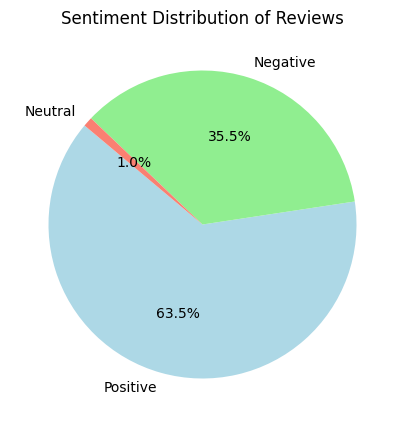

In [38]:
import matplotlib.pyplot as plt

# Sentiment counts for each category
sentiment_counts = reviews_df['Sentiment_Category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 5))  # Set figure size
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution of Reviews')
plt.show()


# Topic Modeling

Topic modeling is a type of statistical modeling for discovering abstract topics that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is one of the most popular topic modeling techniques.

In [43]:
#Step 1: Install Required Libraries
!pip install gensim nltk


In [44]:
#step 2: preprocess the data
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
import gensim

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

# Preprocess the text
def preprocess(text):
    # Tokenize
    tokens = tokenizer.tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return filtered_tokens

# Apply preprocessing to each review
processed_reviews = list(reviews_df['Review'].apply(preprocess))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
#step 3: Create a Dictionary and Corpus
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_reviews)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create a bag-of-words model for each document
corpus = [dictionary.doc2bow(doc) for doc in processed_reviews]


In [46]:
#Step 4: Apply LDA
# Set parameters
num_topics = 5  # Adjust this based on your specific needs

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.042*"said" + 0.028*"people" + 0.028*"attendant" + 0.026*"going" + 0.023*"asking" + 0.020*"husband" + 0.020*"control" + 0.020*"gave" + 0.020*"passport" + 0.020*"centre"
Topic: 1 
Words: 0.039*"class" + 0.027*"business" + 0.026*"seats" + 0.025*"british" + 0.022*"seat" + 0.020*"airways" + 0.018*"row" + 0.018*"service" + 0.018*"boeing" + 0.018*"world"
Topic: 2 
Words: 0.030*"seat" + 0.028*"seats" + 0.025*"business" + 0.024*"class" + 0.016*"economy" + 0.016*"passengers" + 0.015*"cabin" + 0.015*"staff" + 0.014*"crew" + 0.012*"check"
Topic: 3 
Words: 0.020*"london" + 0.016*"airways" + 0.015*"british" + 0.015*"us" + 0.013*"service" + 0.012*"hours" + 0.011*"would" + 0.011*"told" + 0.011*"customer" + 0.010*"airport"
Topic: 4 
Words: 0.032*"good" + 0.027*"food" + 0.023*"service" + 0.021*"crew" + 0.017*"time" + 0.014*"cabin" + 0.014*"club" + 0.013*"lounge" + 0.012*"london" + 0.012*"drinks"


**Insights**

Topic 0 seems to focus on customer service interactions, with words like "said," "people," "attendant," "going," and "asking." This suggests conversations or comments about interactions with airline staff.

Topic 1 involves aspects of seating and class, with words like "class," "business," "seats," "british," "seat," "airways," "row," "service," "boeing," and "world." This topic might be reflecting passengers' experiences or opinions about seating arrangements and comfort during their flights.

Topic 2 includes a mix of terms related to seating again ("seat," "seats"), travel classes ("business," "class," "economy"), and general travel ("passengers," "cabin," "crew," "check"). It could indicate discussions about different travel classes and the associated amenities or services.

Topic 3 seems to be geographically focused, with references to "London," "airways," and "us," and possibly the customer service experience ("service," "hours," "customer," "airport"). This might capture conversations about specific routes or the experience at particular airports.

Topic 4 contains positive descriptors ("good," "food," "service") and mentions of "crew," "time," "cabin," "club," "lounge," "London," and "drinks." This topic might represent positive feedback about the onboard experience, including food and lounge services.

# Word cloud

In [47]:
!pip install wordcloud


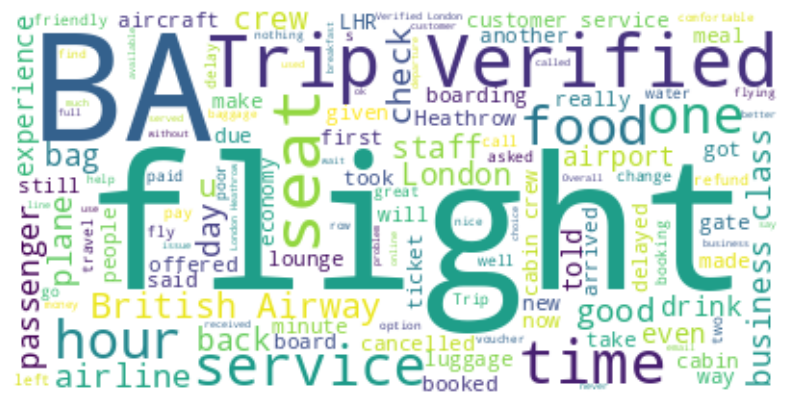

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews into a single string
text = " ".join(review for review in reviews_df['Review'])

# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated word cloud image
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()


**Insights**

The word cloud you generated provides a visual summary of the most prominent words in your review data. Large words in the cloud, such as "flight," "service," "staff," "time," "British," "Airway," and "seat," suggest these are common and significant in the reviews. This visualization indicates key focus areas in customer feedback.

For instance, "flight" and "seat" might indicate passengers are often discussing their seating experience and flight details. "Service" and "staff" being prominent suggests a lot of comments revolve around the service quality. The presence of "British" and "Airway" is expected since the dataset is about British Airways.